## - Import

In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.3.1+cu118
device: cuda


## - Parameters

In [6]:
# Data
train_data_path = './data/Fashion MNIST/fashion-mnist_train.csv' # Path of data
valid_data_path = './data/Fashion MNIST/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4

Train data path: ./data/Fashion MNIST/fashion-mnist_train.csv
Valid data path: ./data/Fashion MNIST/fashion-mnist_test.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [7]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [8]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [9]:
dataset = FashionMNIST(train_data_path, img_size)

Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


In [10]:
dataset[1][0]

In [11]:
class_list[dataset[1][1]]

'Ankle boot'

In [12]:
dataset[10][0]

In [13]:
class_list[dataset[10][1]]

'T-Shirt'

In [14]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [15]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


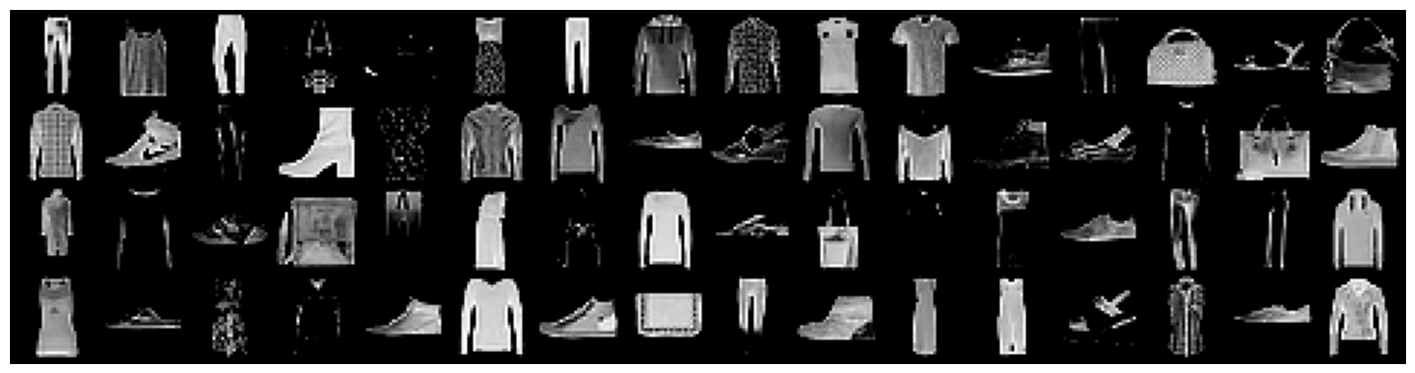

In [16]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## - Generator

In [17]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [19]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [20]:
# Loss function
criterion = nn.BCELoss()

In [21]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [22]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [23]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 3.803286075592041, d_loss: 0.5883234143257141


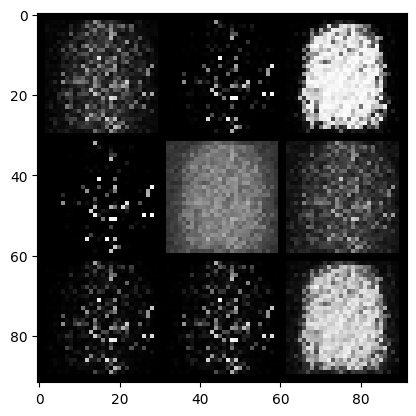

Starting epoch 2...
g_loss: 3.822613477706909, d_loss: 0.24635663628578186


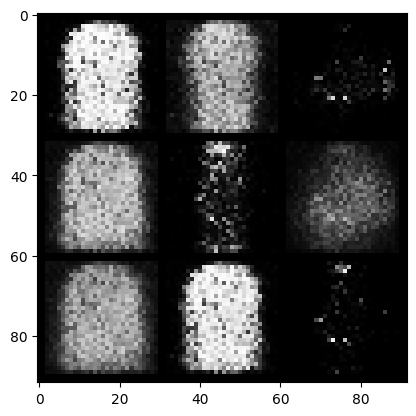

Starting epoch 3...
g_loss: 3.7346811294555664, d_loss: 0.35505950450897217


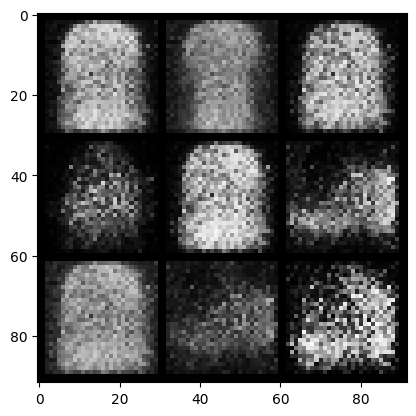

Starting epoch 4...
g_loss: 4.2332258224487305, d_loss: 0.26234957575798035


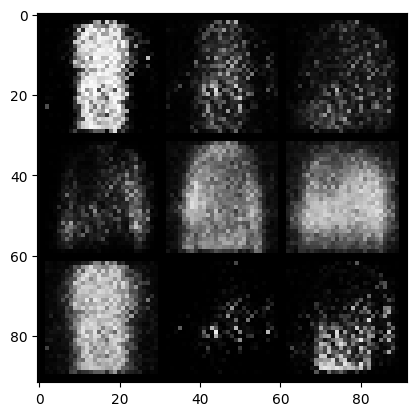

Starting epoch 5...
g_loss: 2.716775417327881, d_loss: 0.6459212303161621


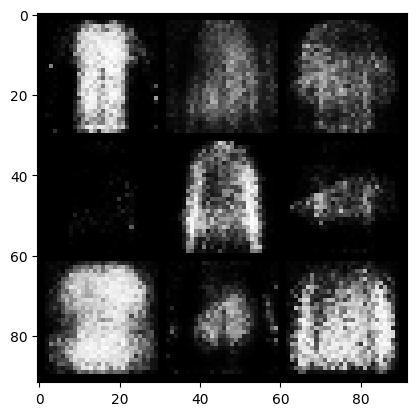

Starting epoch 6...
g_loss: 2.5720276832580566, d_loss: 0.7516282200813293


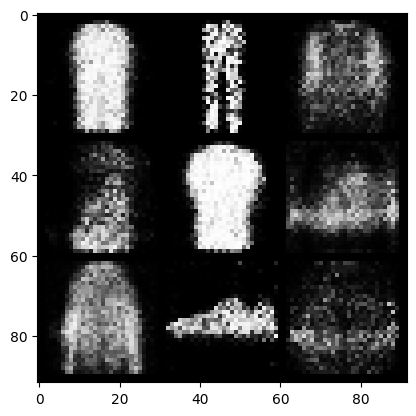

Starting epoch 7...
g_loss: 2.041064739227295, d_loss: 0.8156720399856567


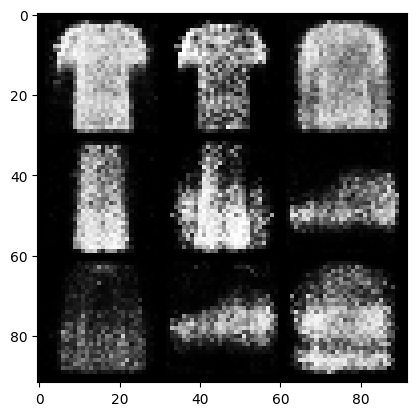

Starting epoch 8...
g_loss: 2.090425729751587, d_loss: 0.7010637521743774


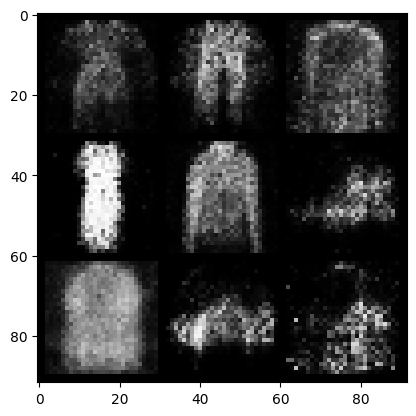

Starting epoch 9...
g_loss: 1.9152940511703491, d_loss: 1.2693290710449219


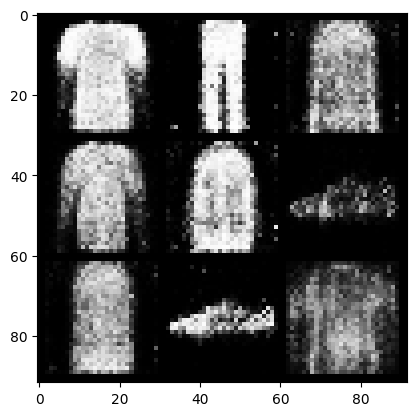

Starting epoch 10...
g_loss: 1.8559620380401611, d_loss: 1.079209804534912


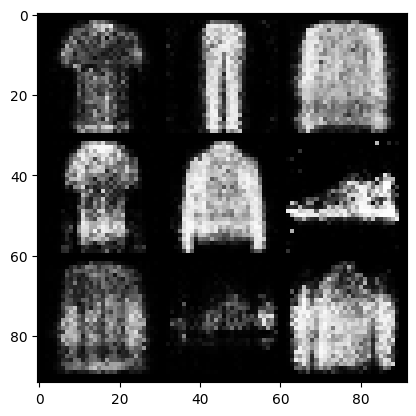

Starting epoch 11...
g_loss: 1.979933261871338, d_loss: 0.6669144630432129


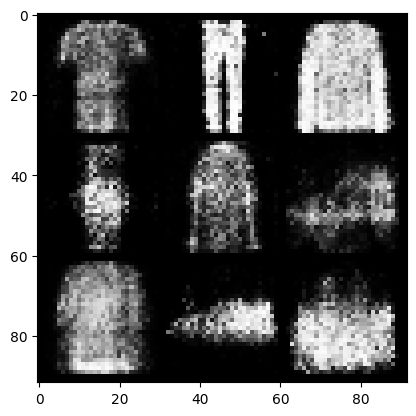

Starting epoch 12...
g_loss: 2.118727684020996, d_loss: 0.4787296652793884


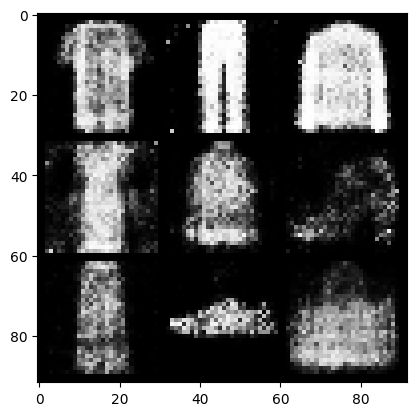

Starting epoch 13...
g_loss: 1.518705129623413, d_loss: 0.8043586015701294


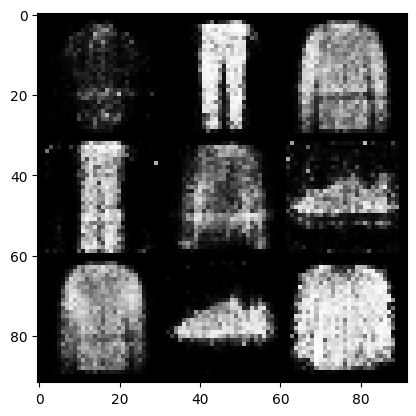

Starting epoch 14...
g_loss: 1.6638801097869873, d_loss: 1.0075417757034302


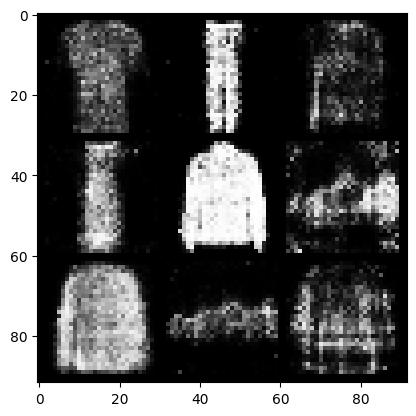

Starting epoch 15...
g_loss: 1.5503809452056885, d_loss: 1.1305029392242432


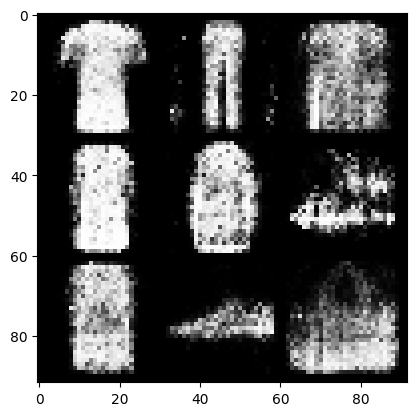

Starting epoch 16...
g_loss: 1.5254662036895752, d_loss: 1.2041137218475342


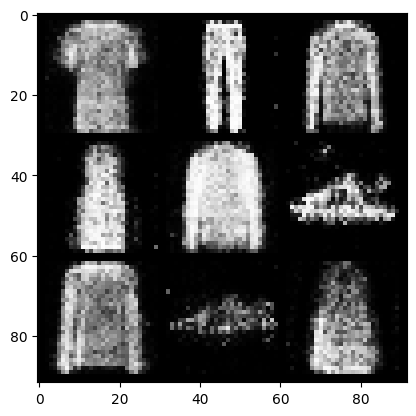

Starting epoch 17...
g_loss: 1.698204755783081, d_loss: 0.7322415113449097


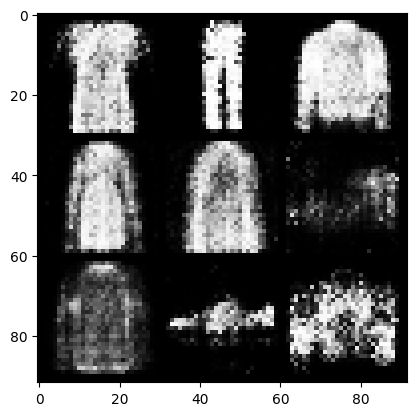

Starting epoch 18...
g_loss: 1.7547087669372559, d_loss: 0.8347027897834778


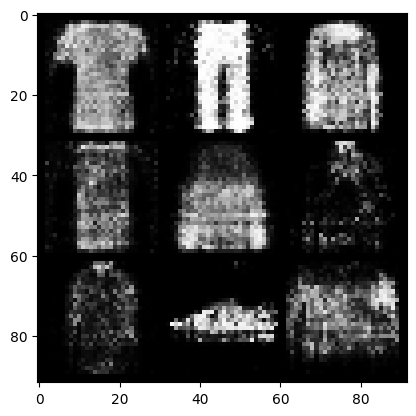

Starting epoch 19...
g_loss: 1.4701032638549805, d_loss: 1.0143693685531616


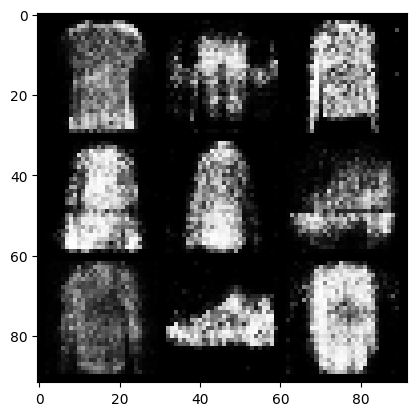

Starting epoch 20...
g_loss: 1.1975290775299072, d_loss: 0.9845760464668274


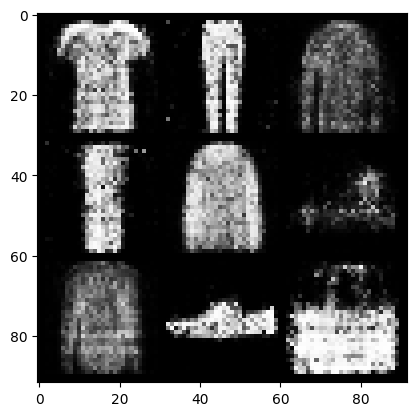

Starting epoch 21...
g_loss: 1.3004980087280273, d_loss: 0.8685755133628845


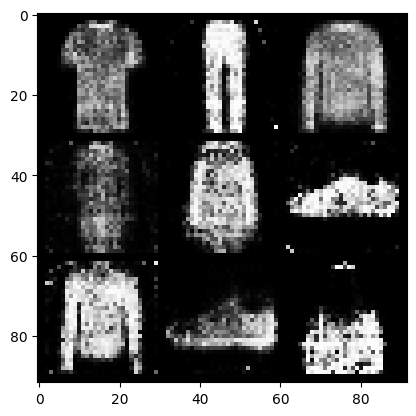

Starting epoch 22...
g_loss: 1.209783911705017, d_loss: 1.2111502885818481


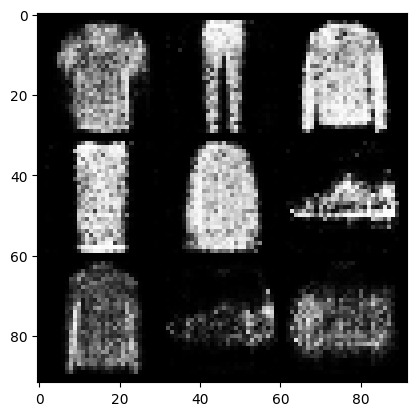

Starting epoch 23...
g_loss: 1.382214069366455, d_loss: 0.994739294052124


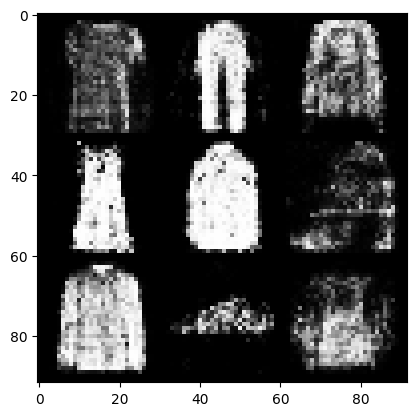

Starting epoch 24...
g_loss: 1.3062584400177002, d_loss: 1.0186192989349365


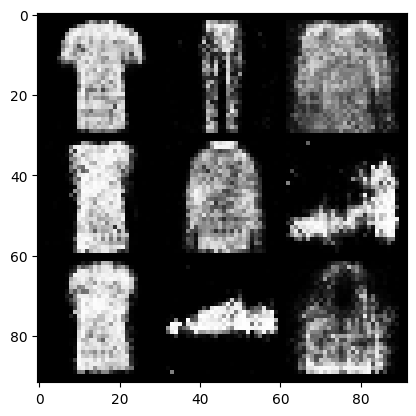

Starting epoch 25...
g_loss: 1.5409801006317139, d_loss: 0.9836333990097046


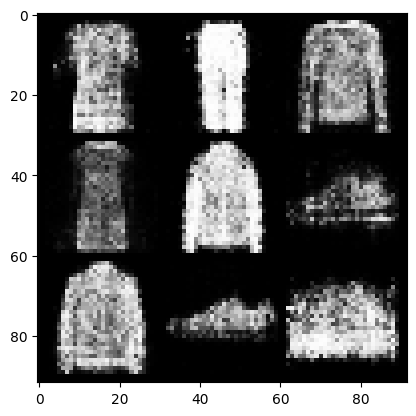

Starting epoch 26...
g_loss: 1.3381767272949219, d_loss: 1.0581220388412476


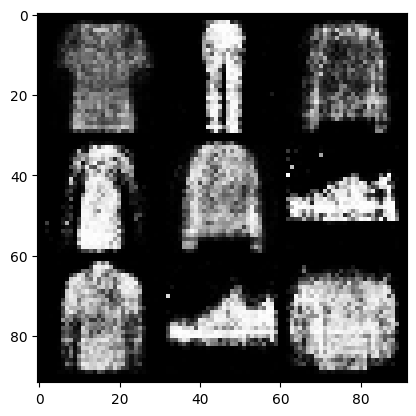

Starting epoch 27...
g_loss: 1.2497906684875488, d_loss: 0.812656044960022


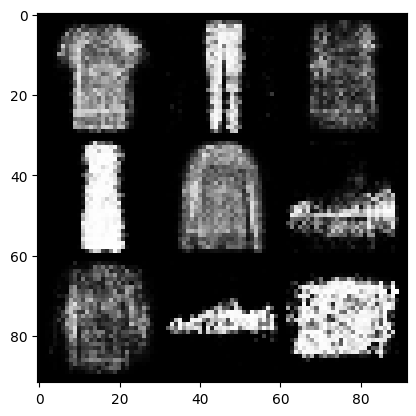

Starting epoch 28...
g_loss: 1.1012417078018188, d_loss: 1.175480842590332


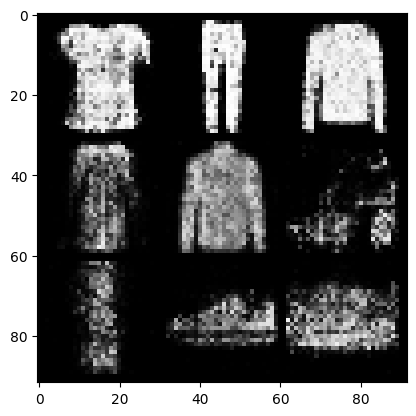

Starting epoch 29...
g_loss: 1.1573002338409424, d_loss: 1.087660789489746


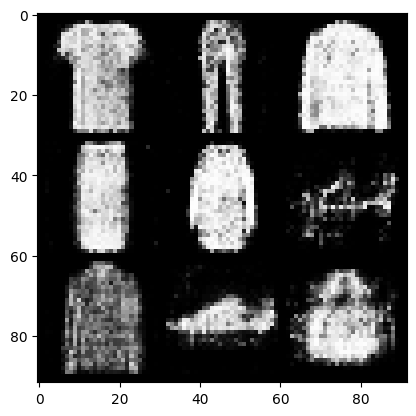

Starting epoch 30...
g_loss: 1.136883020401001, d_loss: 1.1886800527572632


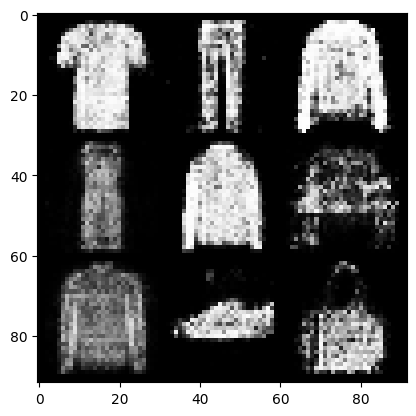

In [24]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(data_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## - Show Generating Images

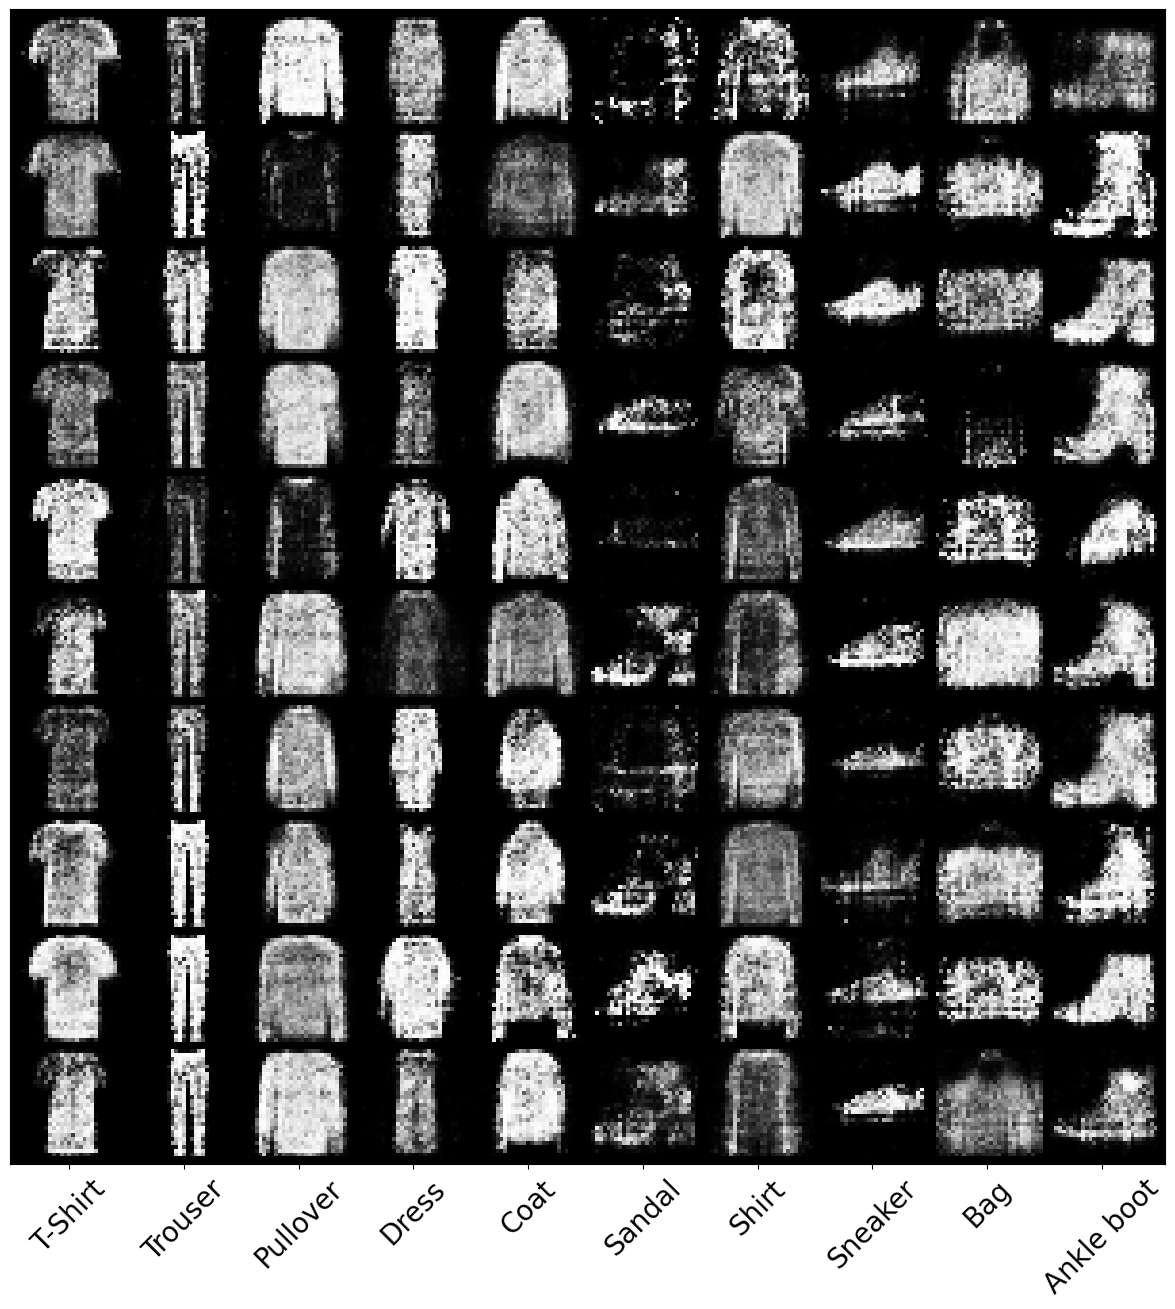

In [25]:
# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)